# Walmart Weekly Sales Forecasting

## Objective
The primary goal of this project is to accurately forecast weekly sales at the department level across various Walmart stores. This is a critical business problem that requires robust time series analysis and machine learning to optimize inventory management, improve supply chain logistics, and inform promotional strategies.

## Methodology
We approach this as a complex time-series regression problem, focusing on modeling the relationships between sales, economic indicators, promotional activities, and strong seasonal patterns.

1. Multi-Source Data Integration: We merged three distinct datasets (Walmart.csv, stores.csv, and features.csv) based on shared keys (Store and Date) to create a single, rich feature set.

2. Feature Engineering: We created highly predictive time-series features, including lagged sales (sales from the previous week) and rolling averages (to capture short-term trend), alongside temporal features (Year, Month, Week) and a customized holiday flag.

3. Advanced Modeling: We used a rigorous sequential train/test split to maintain time-series integrity. We then compared two powerful ensemble models—a Tuned Random Forest Regressor and the XGBoost Regressor.

## Key Achievements
- Achieved an optimal forecast using the XGBoost Regressor, which demonstrated superior performance in minimizing large errors (RMSE) associated with extreme sales spikes.

- The final model achieved a Mean Absolute Error (MAE) of approximately $1,040, demonstrating high accuracy in predicting weekly sales at the Store-Department level.

- Identified that the 4-week Rolling Mean was the single most important feature, confirming that recent sales momentum is the most reliable predictor of immediate future demand.

In [722]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor 
from sklearn.model_selection import GridSearchCV

In [723]:
# A specific style for plots to make them look clean and professional
plt.style.use('fivethirtyeight')

In [724]:
# To avoid plotting in scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [725]:
try:
    df = pd.read_csv('data/raw/train.csv')

    #Load supporting data files
    stores_df = pd.read_csv('data/raw/stores.csv')
    features_df = pd.read_csv('data/raw/features.csv')
except FileNotFoundError:
    print("Error: Required files - train.csv, stores.csv, features.csv were not found.")
    print("Please download them from 'https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast/data'")
    print("and place it in a 'data/raw' folder inside your project")
    exit()

In [726]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [727]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [728]:
df.describe()

,Store,Dept,Weekly_Sales
count,421570.00,421570.00,421570.00
mean,22.20,44.26,15981.26
std,12.79,30.49,22711.18
min,1.00,1.00,-4988.94
25%,11.00,18.00,2079.65
50%,22.00,37.00,7612.03
75%,33.00,74.00,20205.85
max,45.00,99.00,693099.36


In [729]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [730]:
df['Date'] = pd.to_datetime(df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [731]:
# Merge the sales data with the features data
print("Merging sales data with time-variant features (Temperature, CPI, etc.)...")
df = pd.merge(df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

Merging sales data with time-variant features (Temperature, CPI, etc.)...


In [732]:
# Merge the result with the static store metadata (stores_df)
print("Merging with static store metadata (Type, Size)...")
df = pd.merge(df, stores_df, on='Store', how='left')

Merging with static store metadata (Type, Size)...


In [733]:
# Handle Categorical Features (One-Hot Encoding for 'Type')
# 'Type' (A, B, C) is a great feature, but the model needs it to be numerical.
df = pd.get_dummies(df, columns=['Type'], prefix='Type', drop_first=True)
print("\nStore Type converted to numerical features (Type_B, Type_C).")


Store Type converted to numerical features (Type_B, Type_C).


In [734]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Size          421570 non-null  int64         
 15  Type_B        421

### Handling missing data

In [736]:
# Missing Value Imputation (CRITICAL FOR MARKDOWN COLUMNS)
# NaN in MarkDown columns means there was no markdown that week, so we fill them with 0.
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

In [737]:
# Pick a single store to visualize the sales trend over time
store_id = 1
store_df = df[df['Store'] == store_id].copy()

In [738]:
store_df.sort_values('Date', inplace=True)
store_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
4689,1,35,2010-02-05,2770.00,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
4832,1,36,2010-02-05,120.00,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
4975,1,37,2010-02-05,3438.16,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
5118,1,38,2010-02-05,115564.35,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False


In [739]:
store_df.set_index('Date', inplace=True)
store_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_B,Type_C
Date,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
2010-02-05,1,35,2770.00,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
2010-02-05,1,36,120.00,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
2010-02-05,1,37,3438.16,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False
2010-02-05,1,38,115564.35,False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,151315,False,False


## Visualize sales trend for a particular store

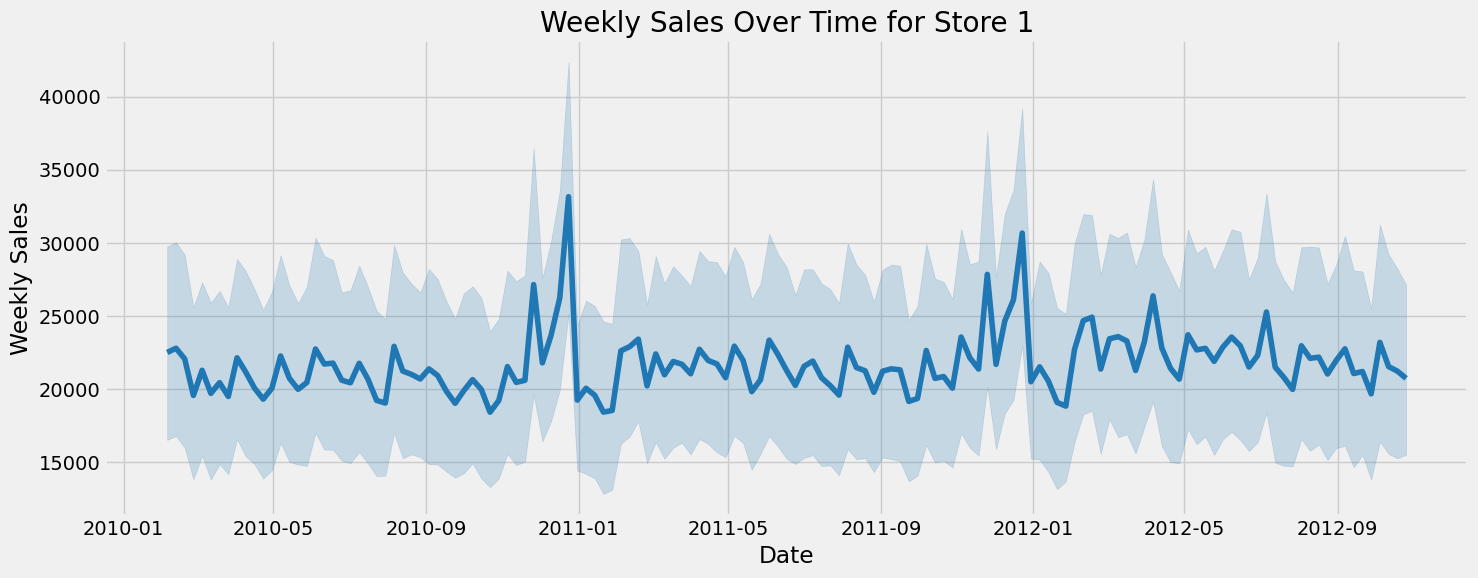

In [741]:
plt.figure(figsize=(15,6))
sns.lineplot(data=store_df, x=store_df.index, y='Weekly_Sales', color='#1f77b4')
plt.title(f'Weekly Sales Over Time for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

There seems to a spike in sales around the holiday period. Let's zoom in to take a closer look.

## Sales Trend during holiday season

In [744]:
# focus on a period from late December to early February to capture holiday season
start_date = '2011-12-01'
end_date = '2012-02-29'
zoom_df = store_df.loc[start_date:end_date]

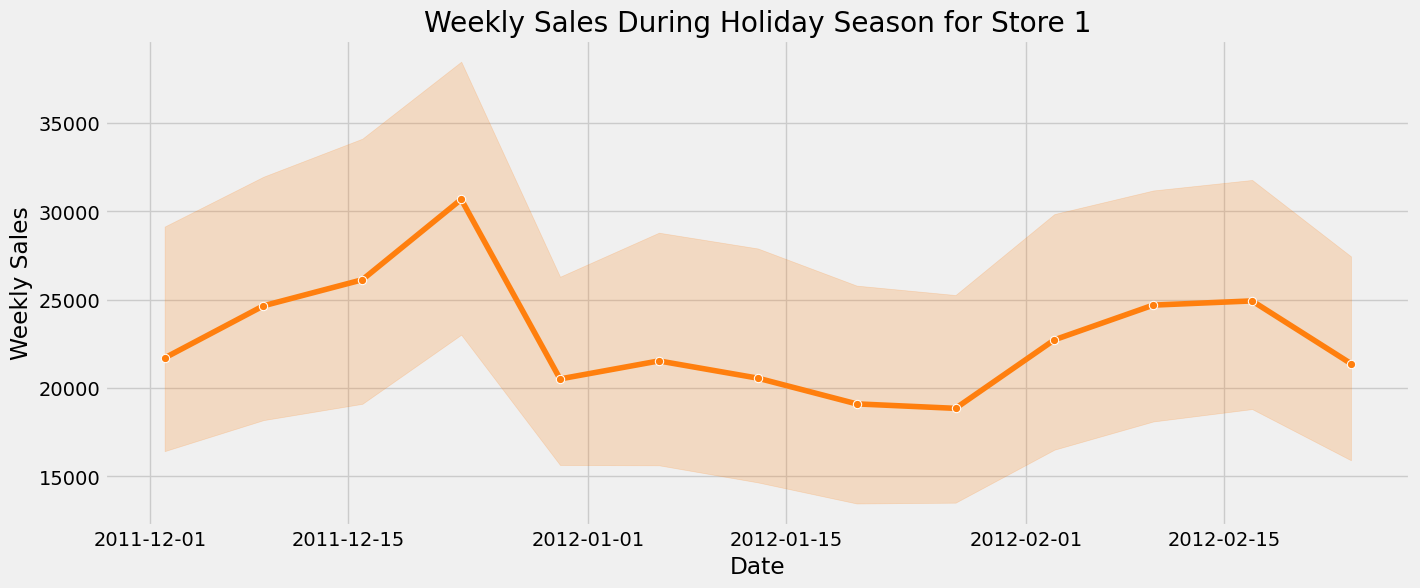

In [745]:
plt.figure(figsize=(15,6))
sns.lineplot(data=zoom_df, x=zoom_df.index, y='Weekly_Sales', color='#ff7f0e', marker='o')
plt.title(f'Weekly Sales During Holiday Season for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)

There is an increase of 10000 in terms of sales during the holiday season of 2011

## Sales trend for all departments

In [748]:
top_n_depts = 15
dept_total_sales = store_df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
top_dept_sales = dept_total_sales.head(top_n_depts)

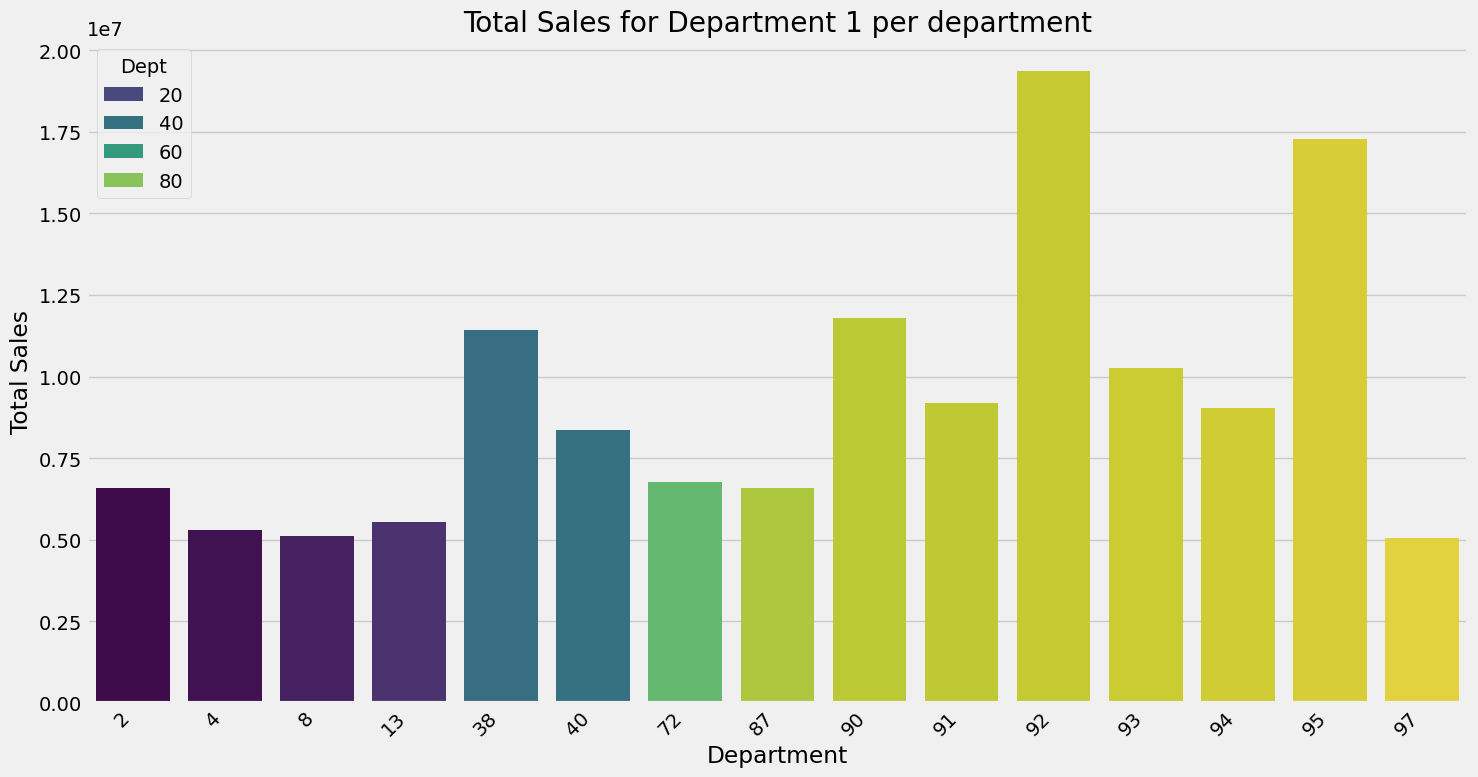

In [749]:
plt.figure(figsize=(15,8))
sns.barplot(x=top_dept_sales.index, y=top_dept_sales.values, palette='viridis', hue=top_dept_sales.index)
plt.title(f'Total Sales for Department {store_id} per department')
plt.xlabel('Department')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize sales trend for a particular department

Let's visualize sales trend for department = 92, which is the top revenue generator for this store

In [752]:
dept_id = 92
dept_df = store_df[store_df['Dept'] == dept_id].copy()

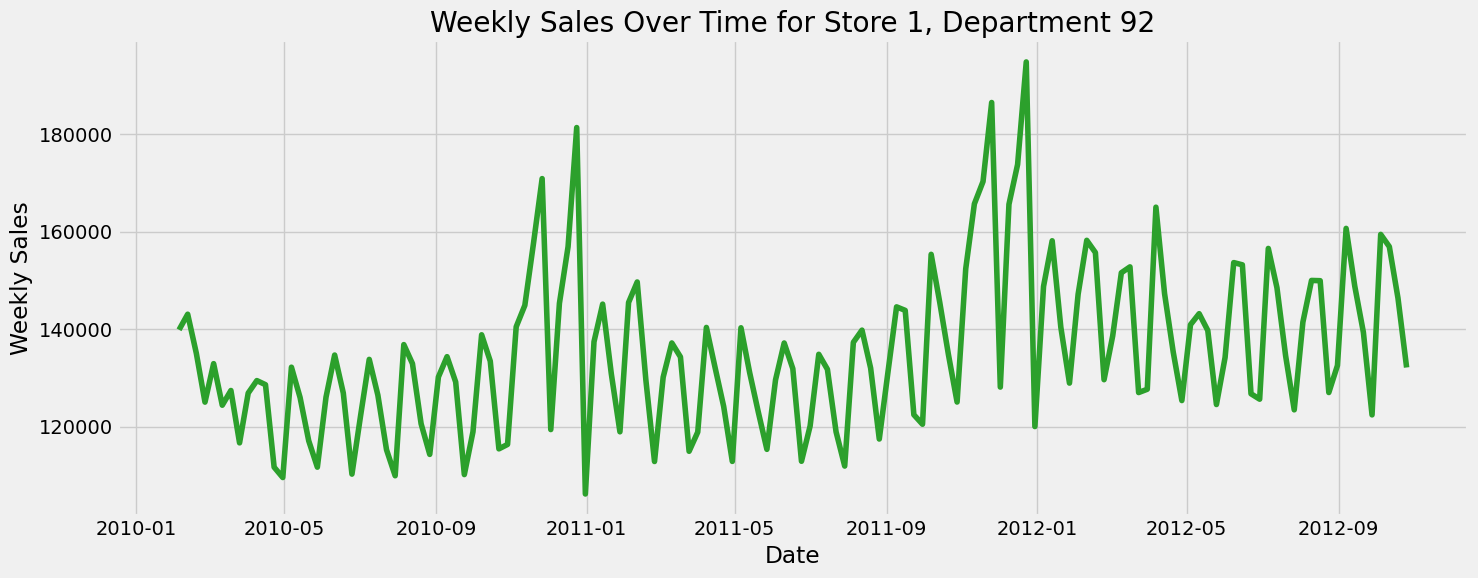

In [753]:
plt.figure(figsize=(15,6))
sns.lineplot(data=dept_df, x=dept_df.index, y='Weekly_Sales', color='#2ca02c')
plt.title(f'Weekly Sales Over Time for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

We see a similar trend with sales spike around the holiday season

## Comparison of Weekly Sales for top departments

In [756]:
top_depts = dept_total_sales.head(5).index.tolist()
top_depts_df = store_df[store_df['Dept'].isin(top_depts)]

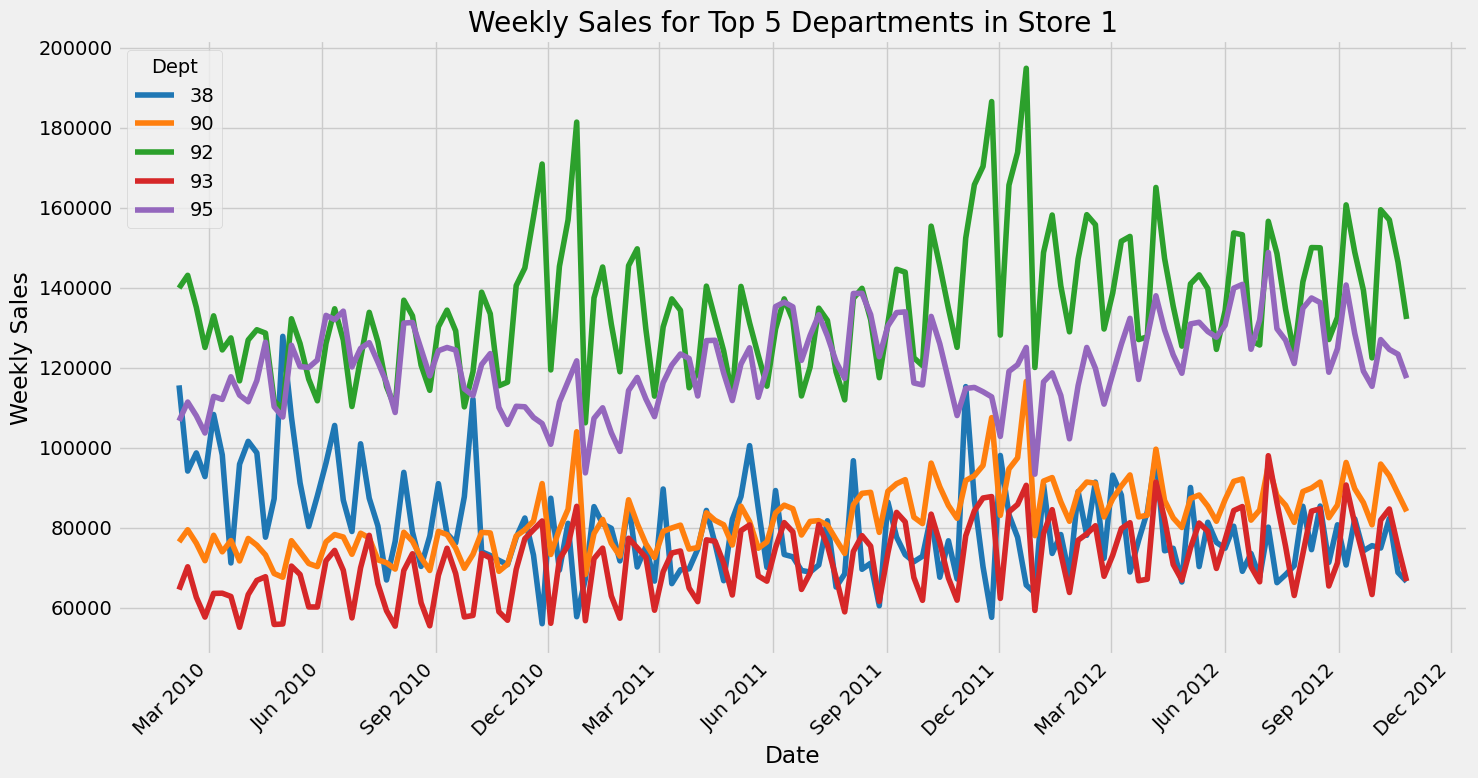

In [757]:
plt.figure(figsize=(15,8))
line_plot=sns.lineplot(data=top_depts_df, x='Date', y='Weekly_Sales', hue='Dept', palette='tab10')

ax = line_plot.get_xaxis()
ax.set_major_locator(MonthLocator(interval=3)) # Show a tick every 3 months
ax.set_major_formatter(DateFormatter('%b %Y')) # Format as e.g. "Jan 2011'

plt.title(f'Weekly Sales for Top 5 Departments in Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate the new labels
plt.tight_layout()
plt.show()

# Feature Engineering

We will create some new features here. For example from `Date` column, we will extract `year`, `month`, `day_of_week`, and `day_of_year`. This allows the model to learn seasonal patterns.

We will also create features that represent the sales from perivious week so that the model understands the short-term trend and momentum of sales.

We will also create rolling avergae of sales over the last 4 weeks, so that the model can capture longer-term trends and smooth out noise. 

In [760]:
def engineer_features(df_in):
    df_out = df_in.copy()
    # Convert Date and set as an index
    df_out['IsHoliday'] = df_out['IsHoliday'].astype(int)
    df_out.set_index('Date', inplace=True)

    # Create time based features
    df_out['Year'] = df_out.index.year
    df_out['Month'] = df_out.index.month
    df_out['Week'] = df_out.index.isocalendar().week.astype(int)
    df_out['Day'] = df_out.index.day
    df_out['DayOfWeek'] = df_out.index.dayofweek

    # Sort data 
    df_out.sort_values(['Store', 'Dept', 'Date'], inplace=True)

    # Lag 1: Sales from the previous week
    df_out['Weekly_Sales_lag_1'] = df_out['Weekly_Sales'].shift(1)

    #Rolling mean: Average sales over the past 4 weeks
    df_out['Weekly_Sales_Rolling_mean_4'] = df_out['Weekly_Sales'].rolling(window=4).mean()

    return df_out


In [761]:
train_df = engineer_features(df.reset_index())
train_df.head()

,index,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Size,Type_B,Type_C,Year,Month,Week,Day,DayOfWeek,Weekly_Sales_lag_1,Weekly_Sales_Rolling_mean_4
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0,1,1,24924.50,0,42.31,2.57,0.00,0.00,0.00,...,151315,False,False,2010,2,5,5,4,NaN,NaN
2010-02-12,1,1,1,46039.49,1,38.51,2.55,0.00,0.00,0.00,...,151315,False,False,2010,2,6,12,4,24924.50,NaN
2010-02-19,2,1,1,41595.55,0,39.93,2.51,0.00,0.00,0.00,...,151315,False,False,2010,2,7,19,4,46039.49,NaN
2010-02-26,3,1,1,19403.54,0,46.63,2.56,0.00,0.00,0.00,...,151315,False,False,2010,2,8,26,4,41595.55,32990.77
2010-03-05,4,1,1,21827.90,0,46.50,2.62,0.00,0.00,0.00,...,151315,False,False,2010,3,9,5,4,19403.54,32216.62


In [762]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   index                        421570 non-null  int64  
 1   Store                        421570 non-null  int64  
 2   Dept                         421570 non-null  int64  
 3   Weekly_Sales                 421570 non-null  float64
 4   IsHoliday                    421570 non-null  int64  
 5   Temperature                  421570 non-null  float64
 6   Fuel_Price                   421570 non-null  float64
 7   MarkDown1                    421570 non-null  float64
 8   MarkDown2                    421570 non-null  float64
 9   MarkDown3                    421570 non-null  float64
 10  MarkDown4                    421570 non-null  float64
 11  MarkDown5                    421570 non-null  float64
 12  CPI                          421570 non-nu

## Modeling and Prediction

In [764]:
# Define features and target 
features = [
    'Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 
    'Unemployment', 'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
    'Type_B', 'Type_C', 
    'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 
    'Weekly_Sales_lag_1', 'Weekly_Sales_Rolling_mean_4'
]
target = 'Weekly_Sales'

In [765]:
X = train_df[features]
y = train_df[target]

In [766]:
# Create a a time-based train/test split (sequential split)
print(f"Data Start Date: {df['Date'].min()}")
print(f"Data End Date: {df['Date'].max()}")
# Choosing July 1, 2012 so that all data before that point (about 2 and a half years) is used for training the model
# and after that reserved for testing
split_date = pd.to_datetime('2012-07-01')

Data Start Date: 2010-02-05 00:00:00
Data End Date: 2012-10-26 00:00:00


In [767]:
X_train = X.loc[X.index < split_date]
X_test = X.loc[X.index >= split_date]
y_train = y.loc[y.index < split_date]
y_test = y.loc[y.index >= split_date]

In [768]:
print(f"Final training samples (before split date): {len(X_train)} samples")
print(f"Final testing samples (after split date): {len(X_test)} samples")

Final training samples (before split date): 371242 samples
Final testing samples (after split date): 50328 samples


In [769]:
### Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [770]:
# Make predictions
predictions = model.predict(X_test)

In [771]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

In [772]:
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

Mean Absolute Error (MAE): $1137.07
Root Mean Squared Error (RMSE): $2482.56


The significant difference between the MAE and RMSE indicates that our model is performing well most of the time, but it is making very large mistakes on a few specific data points.

These large mistakes almost certainly occur during the major holiday peaks (like Thanksgiving and Christmas), where sales spike dramatically. Your current model, while good, is likely underestimating these massive spikes, and the RMSE is heavily punishing those specific prediction failures.


### Hyperparameter tuning using GridSearchCV

In [775]:
param_grid = {
    'n_estimators': [100, 200], # Number of trees
    'max_depth': [15, 20],      # Max depth of each tree
    'min_samples_leaf': [1, 5]  # Minimum samples required at a leaf node
}

In [776]:
cv = GridSearchCV(
    estimator = RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = 3, # 3-fold cross-validation
    verbose = 1,
    n_jobs = -1
)

In [777]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [15, 20], 'min_samples_leaf': [1, 5], 'n_estimators': [100, 200]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [778]:
best_params = cv.best_params_
print(f"Best Random Forest Parameters found: {best_params}")

Best Random Forest Parameters found: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 200}


The best paramters found are:
{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 200}

In [780]:
tuned_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
tuned_rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [781]:
rf_predictions = tuned_rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("\n--- Model A: Tuned Random Forest Evaluation ---")
print(f"MAE: ${rf_mae:.2f}")
print(f"RMSE: ${rf_rmse:.2f}")



--- Model A: Tuned Random Forest Evaluation ---
MAE: $1096.93
RMSE: $2382.43


## XGBoost Regressor

In [783]:
xgb_model = XGBRegressor(
    n_estimators = 500,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    max_depth=10
)

In [784]:
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [785]:
xgb_predictions = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print("\n--- XGBoost Evaluation ---")
print(f"MAE: ${xgb_mae:.2f}")
print(f"RMSE: ${xgb_rmse:.2f}")




--- XGBoost Evaluation ---
MAE: $1039.91
RMSE: $2297.65


In [786]:
best_model = xgb_model if xgb_mae < rf_mae else tuned_rf_model
best_predictions = xgb_predictions if xgb_mae < rf_mae else rf_predictions
best_model_name = "XGBoost" if xgb_mae < rf_mae else "Tuned Random Forest"

print(f"\n--- Best Model Selected for Visualization: {best_model_name} ---")


--- Best Model Selected for Visualization: XGBoost ---


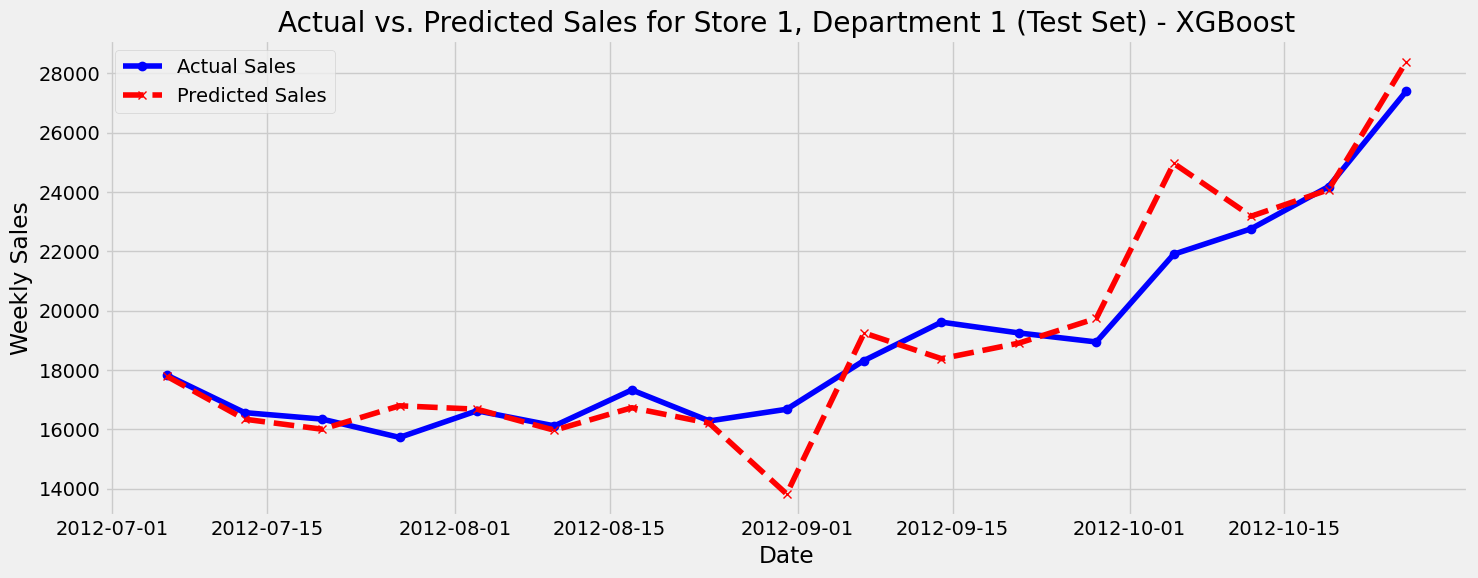

In [787]:
vis_store_id = 1
vis_dept_id = 1

test_df = X_test.copy()
test_df['Actual'] = y_test
test_df['Predicted'] = best_predictions
vis_df = test_df[(test_df['Store'] == vis_store_id) & (test_df['Dept'] == vis_dept_id)]

plt.figure(figsize=(15, 6))
plt.plot(vis_df.index, vis_df['Actual'], label='Actual Sales', color='blue', marker='o')
plt.plot(vis_df.index, vis_df['Predicted'], label='Predicted Sales', color='red', linestyle='--', marker='x')
plt.title(f'Actual vs. Predicted Sales for Store {vis_store_id}, Department {vis_dept_id} (Test Set) - {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature importance of XGBoost

/var/folders/zp/blr2bpbn2p7d9bmv9x75qgn80000gn/T/ipykernel_16732/2505560146.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="mako")


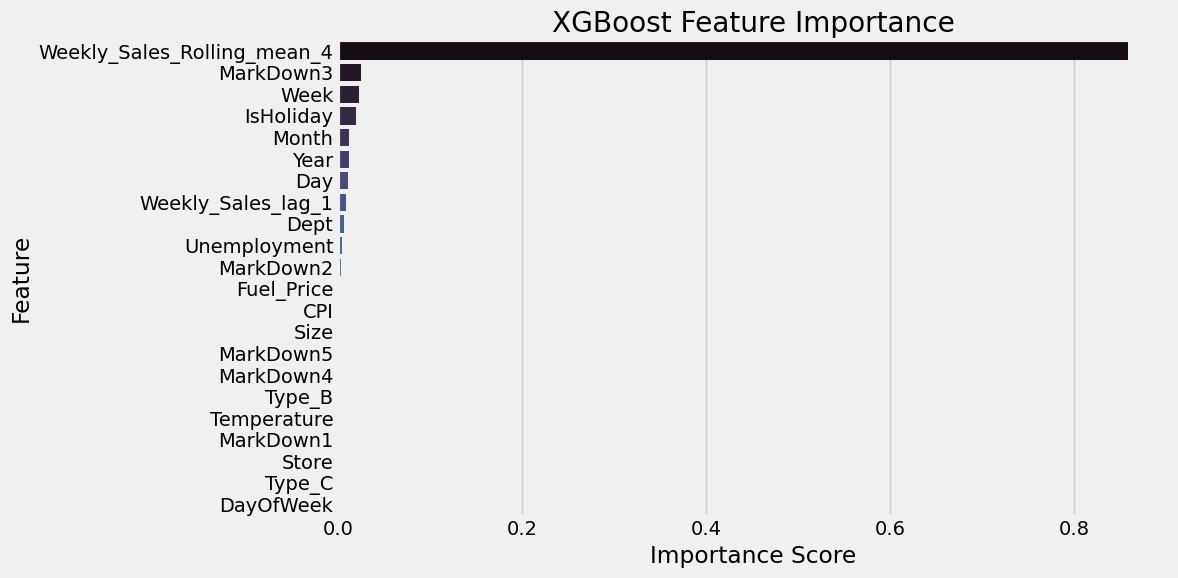

In [789]:
# Plot Feature Importance of the Best Model
feature_importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="mako")
plt.title(f'{best_model_name} Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [869]:
feature_importances

Weekly_Sales_Rolling_mean_4   0.86
MarkDown3                     0.02
Week                          0.02
IsHoliday                     0.02
Month                         0.01
Year                          0.01
Day                           0.01
Weekly_Sales_lag_1            0.01
Dept                          0.01
Unemployment                  0.00
MarkDown2                     0.00
Fuel_Price                    0.00
CPI                           0.00
Size                          0.00
MarkDown5                     0.00
MarkDown4                     0.00
Type_B                        0.00
Temperature                   0.00
MarkDown1                     0.00
Store                         0.00
Type_C                        0.00
DayOfWeek                     0.00
dtype: float32

## Analysis of XGBoost Feature Importance

`Weekly_Sales_Rolling_mean_4` is the dominant Predictor. This single feature accounts for 86% of the model's predictive power. It captures the underlying short-term trend and smooth average of the last four weeks' sales, making it the most robust indicator of current business momentum.

Some other features that contributed to the predictions are:

`MarkDown3`, which often corresponds to the most significant seasonal clearance events (e.g., clearance after Christmas), is the second most important feature. This validates the importance of merging the MarkDown data and imputing missing values with zero.

`Week` - Primary Seasonal Indicator: Captures the core yearly seasonality. The model uses this to understand that certain weeks (like the Thanksgiving or pre-Christmas weeks) inherently have higher sales, regardless of holiday status.

`IsHoliday` - Direct Holiday Flag: This feature is critical for predicting the few peak weeks (like Christmas/New Year's) where sales deviate drastically from the norm.

## Model comparison

In [846]:
comparison_data = {
    'Model': ['Tuned Random Forest', 'XGBoost'],
    'MAE': [rf_mae, xgb_mae],
    'RMSE': [rf_rmse, xgb_rmse]
}
comparison_df = pd.DataFrame(comparison_data)

In [852]:
comparison_df

,Model,MAE,RMSE
0,Tuned Random Forest,1096.93,2382.43
1,XGBoost,1039.91,2297.65


In [848]:
# Reshape data for plotting (long format required for seaborn barplot)
comparison_melted = comparison_df.melt('Model', var_name='Metric', value_name='Error Value')

In [854]:
comparison_melted

,Model,Metric,Error Value
0,Tuned Random Forest,MAE,1096.93
1,XGBoost,MAE,1039.91
2,Tuned Random Forest,RMSE,2382.43
3,XGBoost,RMSE,2297.65


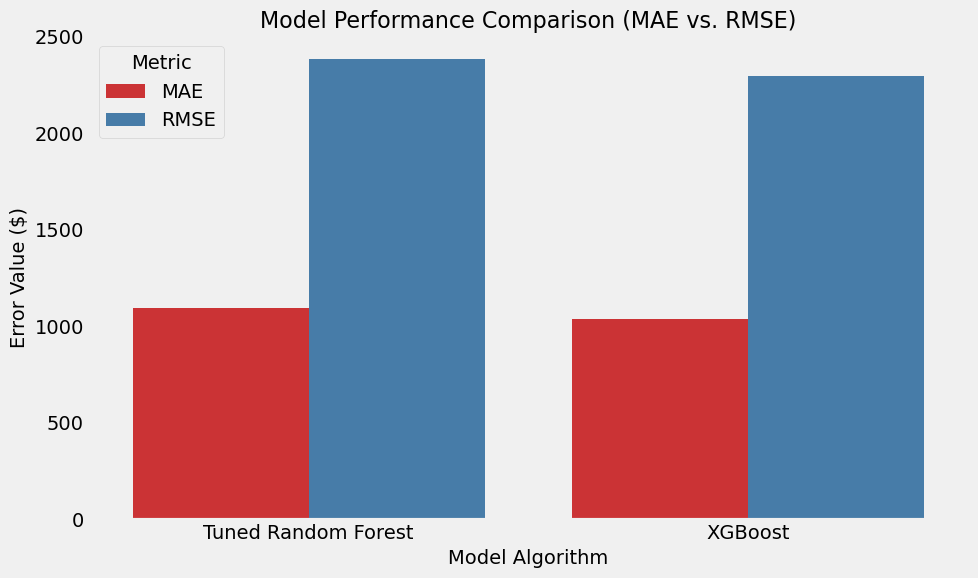

In [858]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Model', 
    y='Error Value', 
    hue='Metric', 
    data=comparison_melted, 
    palette='Set1'
)
plt.title('Model Performance Comparison (MAE vs. RMSE)', fontsize=16)
plt.ylabel('Error Value ($)', fontsize=14)
plt.xlabel('Model Algorithm', fontsize=14)
plt.legend(title='Metric')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [866]:
mae_diff = rf_mae - xgb_mae
mae_diff

57.027653158683506

## Conclusion

The **XGBoost Regressor** is the Champion Model, achieving a 57.027 lower MAE than the Tuned Random Forest.
This marginal yet consistent improvement indicates that the boosting approach handled the non-linear, high-spike sales data more effectively.

Key Feature Insights (from XGBoost Feature Importance):
1. **Lag Sales & Rolling Mean:**
   These time-based feature `Weekly_Sales_Rolling_Mean_4` dominated feature importance, confirming that historical sales are the most predictive factor.
2. **Holiday Impact:**
   The IsHoliday flag was typically a high-ranking predictor, proving the necessity of feature engineering for seasonal spikes.
3. **Department:**
   Indicates that the specific department ID (e.g., Dept 1 vs. Dept 99) provides a unique baseline value for sales, even after accounting for store features.

Next Steps for Productionizing/Improving the Model:
1. **Targeted Tuning:** Further optimize XGBoost parameters (e.g., using RandomizedSearchCV for speed) on a more dense grid.
2. **Feature Enhancement:** Create Store/Department-specific Mean/Median sales features to provide a stronger categorical baseline.")
3. **Ensembling:** Combine the strengths of the Random Forest and XGBoost predictions for a potentially marginal gain.